In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

In [2]:
!pip install -U "scikit-learn<0.24"

  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [63 lines of output]
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation == "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation != "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
    Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
    Using cached wh

In [3]:
!pip install pandas spacy


In [4]:
!pip install scikit-learn

In [5]:
# Library Import
import pandas as pd
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

In [6]:
# Extract sentence from words
def content_extract(file_path='',sep='\t'):
    '''It helps to extract the word based on the separator to form the sentence'''
    try:
        with open (file_path,'r',encoding='utf-8') as text:
            if text.mode  == 'r':
                content = text.readlines()
        sentence = []
        final_sentence=''
        for c in content:
            content_word = c.strip('\n')
            if content_word == '':
                #Once it get matched with separator, it appends previous extracted concatenated string as sentence
#                 final_sentence = re.sub('(?<=[\(]) | (?=[%\',)])','', final_sentence)
                sentence.append(final_sentence.strip(' '))

                #Initialize for next sentence
                final_sentence=''
            else:
                # Till the loop identifies the separator it concatenates string
                final_sentence+=content_word+' '
        print('Total identified value: ',len(sentence),'\n')
        print('Sample display value:\n',sentence[:5])
        return sentence
    except FileNotFoundError:
        print('Check and provide proper file path')

In [7]:
# A class to retrieve the sentences details from the dataframe
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['EOS'] = True

    return features


In [9]:
# Define a function to extract features for a sentence.
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [10]:
# Define a function to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

In [11]:
# Train sentence extraction from dataset
train_sent = content_extract(file_path='train_sent',sep='\n')
print(content_extract)

Total identified value:  2599 

Sample display value:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
<function content_extract at 0x000001AFA17D1BC0>


In [12]:
# Train label extraction from dataset
train_label = content_extract(file_path='train_label',sep='\n')

Total identified value:  2599 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [13]:
# Test sentence extraction from dataset
test_sent = content_extract(file_path='test_sent',sep='\n')

Total identified value:  1056 

Sample display value:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


In [14]:
# Test label extraction from dataset
test_label = content_extract(file_path='test_label',sep='\n')

Total identified value:  1056 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


In [15]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 5.6 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 7.3 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 7.1 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 6.0 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 6.5 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 6.6 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 6.7 MB/s eta 0:00:01
     ----------------------------------- ---- 11.3/12.8 MB 6.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 6.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 6.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
# Import spacy small library to find medical related entities
import spacy
nlp = spacy.load("en_core_web_sm")


In [17]:
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [18]:
import pandas as pd

# Initialize list to store rows
rows = []

i = 0  # Sentence count

# Process each sentence and corresponding labels
for sent, label in zip(train_sent, train_label):
    i += 1  # Increment sentence count
    
    # Process the entire sentence with spaCy
    doc = nlp(sent)
    
    # Tokenize the label string the same way as the sentence
    label_tokens = label.split()  # Assuming labels are split by spaces
    
    # Ensure the sentence and label have the same number of tokens
    if len(doc) != len(label_tokens):
        continue

    # Iterate through tokens and labels
    for tok, l in zip(doc, label_tokens):
        # Append the row to the list
        rows.append([i, tok.text, tok.lemma_, tok.pos_, l])

# Create DataFrame from the list of rows
train_df = pd.DataFrame(rows, columns=['sentence', 'word', 'lemma', 'pos', 'label'])

# Check the resulting DataFrame
train_df.head()


,sentence,word,lemma,pos,label
0,1,All,all,DET,O
1,1,live,live,ADJ,O
2,1,births,birth,NOUN,O
3,1,>,>,X,O
4,1,or,or,CCONJ,O


In [19]:
#train datframe

#i=0 #Sentence count
#j=0 #Iteration count

#for sent,label in zip(train_sent,train_label):
#    i+=1
#   for s,l in zip(sent.split(),label.split()):
#        doc = nlp(s)
#        for tok in doc:
#            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
#            j+=1

In [20]:
#test datframe

#i=0 #Sentence count
#j=0 #Iteration count

#for sent,label in zip(test_sent,test_label):
#    i+=1
#    for s,l in zip(sent.split(),label.split()):
#        doc = nlp(s)
#        for tok in doc:
#            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
#            j+=1

In [21]:
import pandas as pd

# Initialize list to store rows
test_rows = []

i = 0  # Sentence count

# Process each sentence and corresponding labels
for sent, label in zip(test_sent, test_label):
    i += 1  # Increment sentence count
    
    # Process the entire sentence with spaCy
    doc = nlp(sent)
    
    # Tokenize the label string the same way as the sentence
    label_tokens = label.split()  # Assuming labels are split by spaces
    
    # Ensure the sentence and label have the same number of tokens
    if len(doc) != len(label_tokens):
        # Optionally, you can skip these sentences or manually fix them
        continue

    # Iterate through tokens and labels
    for tok, l in zip(doc, label_tokens):
        # Append the row to the list
        test_rows.append([i, tok.text, tok.lemma_, tok.pos_, l])

# Create DataFrame from the list of rows
test_df = pd.DataFrame(test_rows, columns=['sentence', 'word', 'lemma', 'pos', 'label'])

# Check the resulting DataFrame
test_df.head()


,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,SCONJ,O
3,1,all,all,DET,O
4,1,deliveries,delivery,NOUN,O


In [22]:
import pandas as pd

# Assuming train_sent and train_label are already defined
# Clean training data
def clean_text(text):
    return text.strip().lower()  # Adjust cleaning as needed

train_sent = [clean_text(sent) for sent in train_sent]
train_label = [clean_text(label) for label in train_label]

# Initialize list to store rows for the training DataFrame
train_rows = []

# Process each sentence and corresponding labels
for i, (sent, label) in enumerate(zip(train_sent, train_label), start=1):
    doc = nlp(sent)
    label_tokens = label.split()
    
    if len(doc) != len(label_tokens):
        continue

    for tok, l in zip(doc, label_tokens):
        train_rows.append([i, tok.text, tok.lemma_, tok.pos_, l])

# Create the training DataFrame
train_df = pd.DataFrame(train_rows, columns=['sentence', 'word', 'lemma', 'pos', 'label'])

# Assuming test_sent and test_label are defined
# Clean test data
test_sent = [clean_text(sent) for sent in test_sent]
test_label = [clean_text(label) for label in test_label]

# Initialize list to store rows for the test DataFrame
test_rows = []

# Process each sentence and corresponding labels for test data
for i, (sent, label) in enumerate(zip(test_sent, test_label), start=1):
    doc = nlp(sent)
    label_tokens = label.split()

    if len(doc) != len(label_tokens):
        continue

    for tok, l in zip(doc, label_tokens):
        test_rows.append([i, tok.text, tok.lemma_, tok.pos_, l])

# Create the test DataFrame
test_df = pd.DataFrame(test_rows, columns=['sentence', 'word', 'lemma', 'pos', 'label'])

# Check the resulting DataFrames
print("Training DataFrame:")
print(train_df.head())
print("Test DataFrame:")
print(test_df.head())


Training DataFrame:
   sentence    word  lemma    pos label
0         1     all    all    DET     o
1         1    live   live   VERB     o
2         1  births  birth   NOUN     o
3         1       >      >      X     o
4         1      or     or  CCONJ     o
Test DataFrame:
   sentence         word        lemma    pos label
0         1  furthermore  furthermore    ADV     o
1         1            ,            ,  PUNCT     o
2         1         when         when  SCONJ     o
3         1          all          all    DET     o
4         1   deliveries     delivery   NOUN     o


In [24]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
freq_df = pd.DataFrame()
freq_df = pd.concat((train_df,test_df),axis=0)

In [25]:
# Resetting index
freq_df.reset_index(inplace=True,drop=True)

In [26]:
# Top 25 most frequency values for Train and Test related dataset words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

word
patients        263
treatment       193
%               135
cancer          112
study           101
therapy          98
disease          81
effects          71
use              64
cases            63
group            62
results          59
health           55
effect           53
gene             52
children         48
lung             47
cell             46
risk             45
syndrome         45
chemotherapy     45
surgery          44
women            43
patient          41
evidence         40
Name: count, dtype: int64

In [27]:
# Top 25 most frequency values for Train and Test related lemma words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

lemma
patient         304
treatment       199
study           139
%               135
effect          124
cancer          119
case            102
therapy         101
disease          95
group            82
cell             76
use              66
gene             63
result           62
child            58
conclusion       56
health           55
rate             55
mutation         52
drug             51
lung             49
risk             49
method           49
syndrome         47
chemotherapy     45
Name: count, dtype: int64

In [28]:
train_df.head(5)

,sentence,word,lemma,pos,label
0,1,all,all,DET,o
1,1,live,live,VERB,o
2,1,births,birth,NOUN,o
3,1,>,>,X,o
4,1,or,or,CCONJ,o


In [29]:
test_df.head(5)

,sentence,word,lemma,pos,label
0,1,furthermore,furthermore,ADV,o
1,1,",",",",PUNCT,o
2,1,when,when,SCONJ,o
3,1,all,all,DET,o
4,1,deliveries,delivery,NOUN,o


In [30]:
# Fetch detail view of sentence for train set
train_sent_obj = sentencedetail(train_df)
train_sent_detail = train_sent_obj.sentences

In [31]:
# Display one sentence detail view for train set
train_sent_detail[0]

[('all', 'DET', 'o'),
 ('live', 'VERB', 'o'),
 ('births', 'NOUN', 'o'),
 ('>', 'X', 'o'),
 ('or', 'CCONJ', 'o'),
 ('=', 'PRON', 'o'),
 ('23', 'NUM', 'o'),
 ('weeks', 'NOUN', 'o'),
 ('at', 'ADP', 'o'),
 ('the', 'DET', 'o'),
 ('university', 'PROPN', 'o'),
 ('of', 'ADP', 'o'),
 ('vermont', 'PROPN', 'o'),
 ('in', 'ADP', 'o'),
 ('1995', 'NUM', 'o'),
 ('(', 'PUNCT', 'o'),
 ('n', 'CCONJ', 'o'),
 ('=', 'SYM', 'o'),
 ('2395', 'NUM', 'o'),
 (')', 'PUNCT', 'o'),
 ('were', 'AUX', 'o'),
 ('retrospectively', 'ADV', 'o'),
 ('analyzed', 'VERB', 'o'),
 ('for', 'ADP', 'o'),
 ('delivery', 'NOUN', 'o'),
 ('route', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('indication', 'NOUN', 'o'),
 ('for', 'ADP', 'o'),
 ('cesarean', 'ADJ', 'o'),
 (',', 'PUNCT', 'o'),
 ('gestational', 'ADJ', 'o'),
 ('age', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('parity', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('and', 'CCONJ', 'o'),
 ('practice', 'NOUN', 'o'),
 ('group', 'NOUN', 'o'),
 ('(', 'PUNCT', 'o'),
 ('to', 'PART', 'o'),
 ('reflect', 'VER

In [32]:
# Fetch detail view of sentence for train set
test_sent_obj = sentencedetail(test_df)
test_sent_detail = test_sent_obj.sentences

In [33]:
# Display one sentence detail view for train set
test_sent_detail[0]

[('furthermore', 'ADV', 'o'),
 (',', 'PUNCT', 'o'),
 ('when', 'SCONJ', 'o'),
 ('all', 'DET', 'o'),
 ('deliveries', 'NOUN', 'o'),
 ('were', 'AUX', 'o'),
 ('analyzed', 'VERB', 'o'),
 (',', 'PUNCT', 'o'),
 ('regardless', 'ADV', 'o'),
 ('of', 'ADP', 'o'),
 ('risk', 'NOUN', 'o'),
 ('status', 'NOUN', 'o'),
 ('but', 'CCONJ', 'o'),
 ('limited', 'VERB', 'o'),
 ('to', 'ADP', 'o'),
 ('gestational', 'ADJ', 'o'),
 ('age', 'NOUN', 'o'),
 ('>', 'PUNCT', 'o'),
 ('or', 'CCONJ', 'o'),
 ('=', 'PRON', 'o'),
 ('36', 'NUM', 'o'),
 ('weeks', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('the', 'DET', 'o'),
 ('rates', 'NOUN', 'o'),
 ('did', 'AUX', 'o'),
 ('not', 'PART', 'o'),
 ('change', 'VERB', 'o'),
 ('(', 'PUNCT', 'o'),
 ('12.6', 'NUM', 'o'),
 ('%', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('280', 'NUM', 'o'),
 ('of', 'ADP', 'o'),
 ('2214', 'NUM', 'o'),
 (';', 'PUNCT', 'o'),
 ('primary', 'ADJ', 'o'),
 ('9.2', 'NUM', 'o'),
 ('%', 'NOUN', 'o'),
 (',', 'PUNCT', 'o'),
 ('183', 'NUM', 'o'),
 ('of', 'ADP', 'o'),
 ('1994', '

In [34]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent2features(s) for s in train_sent_detail]
X_test = [sent2features(s) for s in test_sent_detail]

In [35]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent2labels(l) for l in train_sent_detail]
y_test = [sent2labels(l) for l in test_sent_detail]

In [36]:
from sklearn_crfsuite import CRF

# Example data (replace with your actual data)
X_train = [sent2features(s) for s in train_sent_detail]
    
y_train = [sent2labels(l) for l in train_sent_detail]


# Initialize the CRF model
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

# Fit the model
try:
    crf.fit(X_train, y_train)
    print("Model fitted successfully!")
except Exception as e:
    print("Error:", e)


Model fitted successfully!


In [37]:
# Calculate the f1 score using the test data
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 90.65 % 


In [38]:
!pip install matplotlib


In [39]:
!pip install seaborn


Predicted F1-score for Medical Entity Dataset is: 90.65 % 
Classification Accuracy: 0.9148164929768917
Classification Report

              precision    recall  f1-score   support

           d       0.79      0.57      0.66       931
           o       0.93      0.98      0.95      9573
           t       0.68      0.38      0.49       531

    accuracy                           0.91     11035
   macro avg       0.80      0.64      0.70     11035
weighted avg       0.91      0.91      0.91     11035

Confusion Matrix

[[ 531  388   12]
 [ 128 9362   83]
 [  11  318  202]]


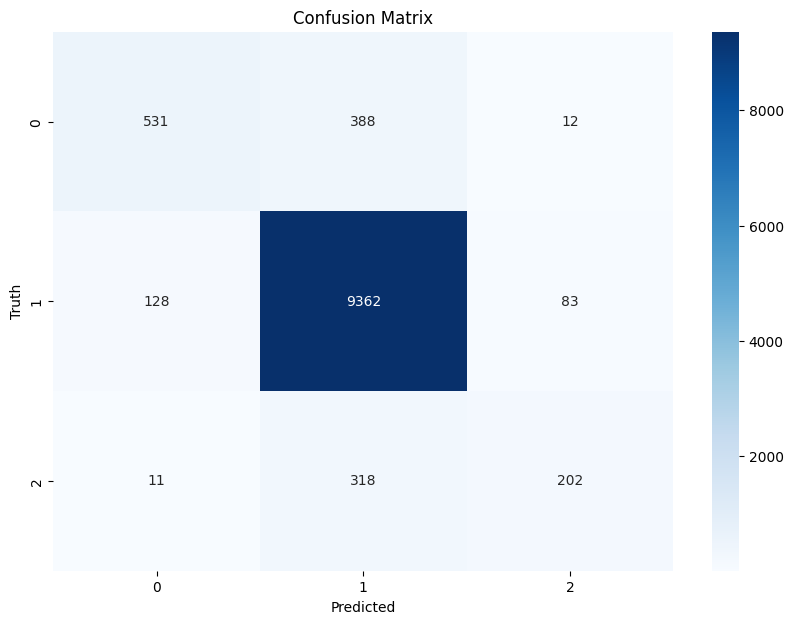

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn



# Flatten the sequences in y_test and y_pred
y_test_flat = [label for seq in y_test for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

# Calculate and print the F1-score
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100, 2)))

# Evaluate the model

# Calculate and print the Classification Accuracy
print("Classification Accuracy:", accuracy_score(y_test_flat, y_pred_flat))

# Generate and print the Classification Report
print("Classification Report\n")
print(classification_report(y_test_flat, y_pred_flat))

# Generate and print the Confusion Matrix
print("Confusion Matrix\n")
cm = confusion_matrix(y_test_flat, y_pred_flat)
print(cm)

# Plot the Confusion Matrix as a heatmap
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Taken out predicted label from the model
pred_label=[]
for i in y_pred:
    pred_label.extend(i)

In [42]:
# Loaded into test dataframe
test_df['label_predicted'] = pred_label

In [43]:
# Visualise top 5 data
test_df.head(5)

,sentence,word,lemma,pos,label,label_predicted
0,1,furthermore,furthermore,ADV,o,o
1,1,",",",",PUNCT,o,o
2,1,when,when,SCONJ,o,o
3,1,all,all,DET,o,o
4,1,deliveries,delivery,NOUN,o,o


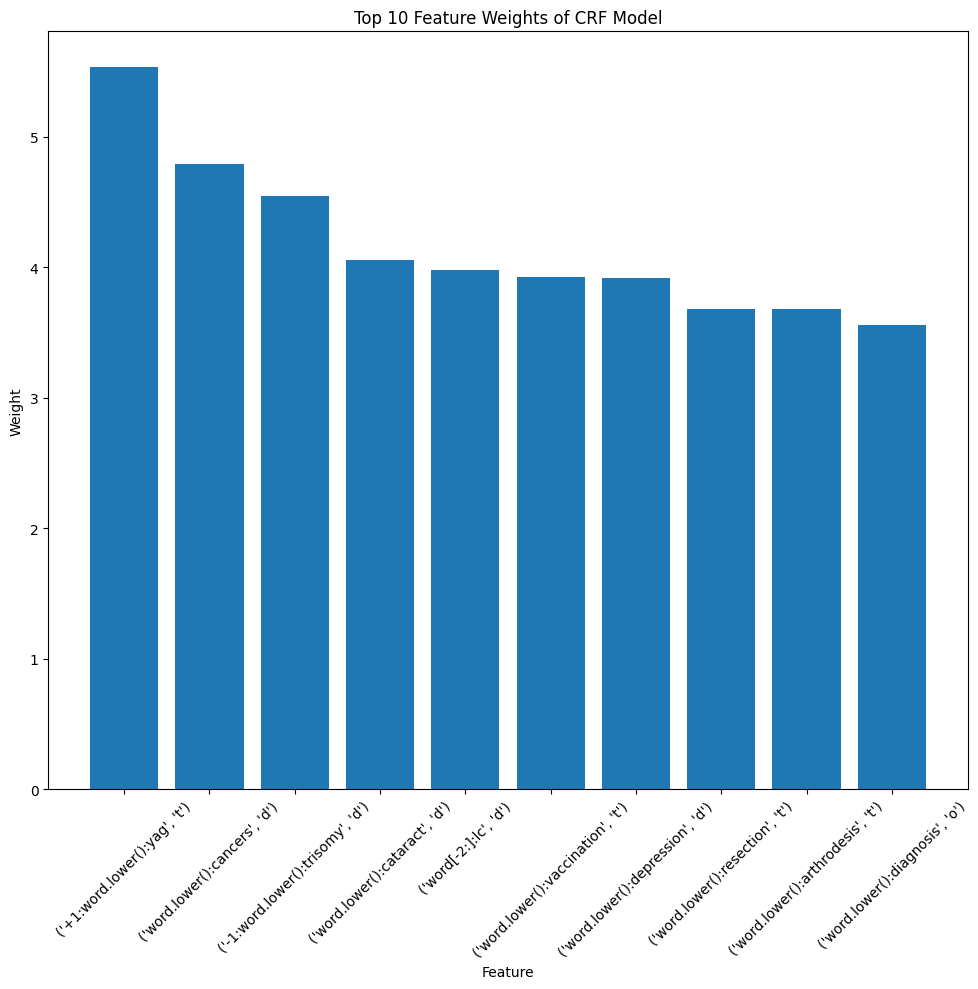

In [61]:
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF

# Assuming crf is your trained CRF model
# Example: crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)
# crf.fit(X_train, y_train)

# Get the model's state features (weights)
state_features = crf.state_features_

# Extract and sort features based on their absolute weights across all labels
sorted_features = sorted(state_features.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract top 30 features and their weights
top_features = sorted_features[:10]
top_feature_names = [f[0] for f in top_features]
top_weights = [f[1] for f in top_features]

# Plotting top weights
plt.figure(figsize=(10, 10))
plt.bar(range(len(top_weights)), top_weights, align='center')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Top 10 Feature Weights of CRF Model')
plt.xticks(range(len(top_weights)), top_feature_names, rotation=45)
plt.tight_layout()
plt.show()
